# TUD IS sentiment analysis tool
This notebook can be used as a tool for  Sentiment Analysis of Tweets from Twitter with the Google Natural Language API about given keywords.

## Sinn und Zweck des Tools

Mit dem Tool kann das Sentiment für einen Begriff über einen Zeitabschnitt in einem Liniendiagramm dargestellt werden. Das Sentiment soll die vorherrschende emotionale Stimmung darstellen, um zu erkennen, ob der Autor eine positive, negative oder neutrale Einstellung hat. Das Sentiment wird dabei auf Basis von Tweets zu dem gesuchten Begriff errechnet. Das Sentiment der Tweets berechnet die Google Cloud Natural Language API. Ziel ist es einen Überblick über die allgemeine Stimmung zu verschiedenen Themen zu bekommen und wie sich diese Stimmung im Zeitverlauf verändert.
Da es für viele Begriffe sehr viele Tweets gibt, die nicht alle Analysiert werden können, werden die 1000 populärsten Tweets für jeden Tag zusammengefasst. Für die zusammengefassten Tweets wird das Sentiment berechnet und in die Grafik aufgenommen. Es ist auch möglich die Tweets für jede Stunde zusammen zu fassen und ein Sentiment dafür zu berechnen.
Google ermöglicht zwei Arten der Sentiment Analyse zum einen die Berechnung des generellen Sentiments und zum anderen die Berechnung des Sentiments für eine Entität des Textes. Entitäten sind dabei Eigennamen oder Gattungsnamen. Beispiel: Bei einer Analyse eines Textes über einen Sportler kann zum einen das allgemeine Sentiment über den Text errechnet werden. Es ist allerdings auch möglich den Namen des Sportlers als Entität zu nutzen. Google versucht dann die emotionale Stimmung im Text gegenüber dem Sportler also der Entität zu berechnen. Da Google die Sentiment Analyse pro Entität momentan nur in Englisch, Japanisch, Spanisch unterstützt wird in diesem Tool auf das allgemeine Sentiment zurückgegriffen. Das Tool ist zunächst auf Englisch, Deutsch, Französisch und Spanisch begrenzt kann aber erweitert werden auf alle Sprachen die Google Cloud Natural Language API unterstützt.
Google errechnet zwei Werte, die das Sentiment ausdrücken. Der Wert score gibt die allgemeine emotionale Tendenz eines Dokuments an und liegt zwischen -1 und 1. Der Wert magnitude gibt die allgemeine Stärke der (sowohl positiven als auch negativen) Stimmung im jeweiligen Text zwischen 0.0 und +inf an.

## Zeitaufwand/Performance
Für den Suchbegriff „artificial intelligence“ für die letzten 12 Monate braucht das Tool xx min um die Tweets herunter zu laden, das Sentiment zu berechnen und die Grafik darzustellen.

## Preparations

Installation of python requirements

In [12]:
!pip install searchtweets-v2 google-cloud-language==2.2.2 pandas==1.3.3

You should consider upgrading via the 'C:\Users\Lukas\.virtualenvs\tud-is-sentiment-eogrpOkI\Scripts\python.exe -m pip install --upgrade pip' command.


In [13]:
import os
import time
from datetime import date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from google.cloud import language
from google.auth import load_credentials_from_file
from searchtweets import ResultStream, gen_request_parameters, load_credentials


## Input

The following parameters for the search are available:

- `start_time`: Starting date for the analysis
- `time_interval`: Interval in which new tweets are grouped together for sentiment analysis
- `time_steps`: Number of intervals to download
- `search_term`: Search Term
- `countries`: List of countries to download tweets for
- `languages`: List of languages to plot

In [14]:
'''
Example searches
start_time = date(2018, 1, 1)
time_interval = 7
time_steps = 52+52+52+40

search_term = 'cannabis'

start_time = date(2018, 1, 1)
time_interval = 7
time_steps = 52+52+52+40

search_term = 'climate change'

start_time = date(2020, 1, 1)
time_interval = 7
time_steps = 52+40


search_term = 'ampelkoalition'
'''

start_time = date(2020, 1, 1)
time_interval = 7
time_steps = 52+40


search_term = 'facebook'

countries = ['US', 'DE', 'FR', 'ES', 'JP']
languages = ['en', 'de', 'fr', 'es', 'jp']

group_on = 'country' # country oder lang

plotted_value = 'sentiment'#'sentiment' # 'magnitude', 'tweets'

## Credentials and Caching

This Notebook makes use of external tools that require credentials these these credentials can be loaded from Google drive in a Google-Colab environment. For this the variable `drive_path` must contain the name of a drive folder where the cache and the credentials are located

In [15]:
drive_path = 'tud-is-sentiment'

try:
    from google.colab import drive
    drive.mount('/content/drive/')
    cache_directory = os.path.join('/content/drive/MyDrive', drive_path, 'cache')
    credentials_directory = os.path.join('/content/drive/MyDrive', drive_path, 'credentials')
except ModuleNotFoundError:
    cache_directory = './cache'
    credentials_directory = './credentials'

### Preparations Google NLP-API
To authenticate against the Google NLP-API an enviromentvariable a credentials file must be present in the executing environment in the above configured directory. More information about how to create such a credentials file can be found in the [official documentation](https://cloud.google.com/natural-language/docs/quickstart-client-libraries?hl=de).

In addition the `analyze_text`-function uses a basic caching mechanism to save on API-Calls and network time.

In [16]:
# Instantiates a client
nlp_client = language.LanguageServiceClient(
    credentials=load_credentials_from_file(os.path.join(credentials_directory, 'tud-is-sentiment.json'))[0])


def analyze_text(text, scope='document'):
    cache_path = os.path.join(cache_directory, '00-sentiment-cache.pckl')

    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    try:
        df = pd.read_pickle(cache_path)
    except FileNotFoundError:
        df = pd.DataFrame(columns=['text', 'scope', 'score', 'magnitude'])

    cache_result = df[(df.text == text) & (df.scope == scope)]

    if len(cache_result) == 1:
        return cache_result.iloc[0].score, cache_result.iloc[0].magnitude

    document = language.Document(
        content=text, type_=language.Document.Type.PLAIN_TEXT
    )

    f = nlp_client.analyze_entity_sentiment if scope == 'entity' else nlp_client.analyze_sentiment
    analysis = f(request={'document': document})

    df = df.append({
        'text': text,
        'scope': scope,
        'score': analysis.document_sentiment.score,
        'magnitude': analysis.document_sentiment.magnitude
    }, ignore_index=True)
    df.to_pickle(cache_path)

    return analysis.document_sentiment.score, analysis.document_sentiment.magnitude


### Preparations for Twitter-API
Tweets from twitter are fetched using the search-tweets library. To fetch tweets a `fetch-tweets`-function is defined that returns tweets for the query from a disk cache if possible. To authenticate against the Twitter-API a yml file with credentials must be present in the above configured credentials directory.

[https://github.com/twitterdev/search-tweets-python/tree/v2](https://github.com/twitterdev/search-tweets-python/tree/v2)

In [17]:
twitter_credentials_filename = os.path.join(credentials_directory, 'twitter-academic.yml')

search_args_all = load_credentials(
    filename=twitter_credentials_filename,
    yaml_key="search_all_tweets_v2"
)

search_args_recent = load_credentials(
    filename=twitter_credentials_filename,
    yaml_key="search_recent_tweets_v2"
)


def fetch_tweets(search_term, start_time=start_time, end_time=start_time + timedelta(days=time_interval), country="US", credentials=search_args_all, max_tweets=10000, skip_cache=False):
    query = "{} place_country:{} -is:retweet -has:links".format(search_term, country)
    filename = ''.join(
        l for l in "{} start_time={} end_time={}".format(query, start_time, end_time, country) if l not in [' ', ':']
    )

    cache_path = os.path.join('.', cache_directory, '{}.pckl'.format(filename))

    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    try:
        if skip_cache:
            raise FileNotFoundError()
        df = pd.read_pickle(cache_path)

    except (FileNotFoundError, AttributeError):
        time.sleep(0.5) # wait a bit to prevent constant 429 http error codes (too many requests)
        tweet_fields = [
            'id',
            'created_at',
            'text',
            'lang',
            'geo',
            'source'
        ]

        rs = ResultStream(
            request_parameters=gen_request_parameters(
                query,
                None,
                results_per_call=min(500, max_tweets),
                tweet_fields=','.join(tweet_fields),
                start_time=str(start_time),
                end_time=str(end_time)
            ),
            max_tweets=max_tweets,
            **credentials
        )
        
        df = pd.DataFrame(

            data=sum([page['data'] for page in rs.stream()], [])
        )

        try: # these functions chrash on "empty" dataframes
            df = df.convert_dtypes()
            df['created_at'] = pd.to_datetime(df['created_at'])
        except:
            pass

        df.to_pickle(cache_path)

    return df


In [18]:
df = None

for country in countries:
    end = start_time

    for week in range(time_steps):
        start = end
        end = start + timedelta(days=time_interval)
        tweets = fetch_tweets(
            search_term,
            start_time=start,
            end_time=end,
            country=country,
            max_tweets=100,
            skip_cache=False
        )
        tweets['country'] = country
        print("country: {} week: {} start: {}, end: {} number of tweets: {}".format(
            country, week, start, end, len(tweets))
        )
        
        if df is None:
            df = tweets
        else:
            df = df.append(tweets, ignore_index=True)

print(len(df))


country: US week: 0 start: 2020-01-01, end: 2020-01-08 number of tweets: 199
country: US week: 1 start: 2020-01-08, end: 2020-01-15 number of tweets: 196
country: US week: 2 start: 2020-01-15, end: 2020-01-22 number of tweets: 100
country: US week: 3 start: 2020-01-22, end: 2020-01-29 number of tweets: 197
country: US week: 4 start: 2020-01-29, end: 2020-02-05 number of tweets: 100
country: US week: 5 start: 2020-02-05, end: 2020-02-12 number of tweets: 194
country: US week: 6 start: 2020-02-12, end: 2020-02-19 number of tweets: 198
country: US week: 7 start: 2020-02-19, end: 2020-02-26 number of tweets: 197
country: US week: 8 start: 2020-02-26, end: 2020-03-04 number of tweets: 197
country: US week: 9 start: 2020-03-04, end: 2020-03-11 number of tweets: 196
country: US week: 10 start: 2020-03-11, end: 2020-03-18 number of tweets: 197
country: US week: 11 start: 2020-03-18, end: 2020-03-25 number of tweets: 196
country: US week: 12 start: 2020-03-25, end: 2020-04-01 number of tweets: 

 HTTP Error code: 429: Rate limit exceeded
 | Too Many Requests
 Request payload: {'query': 'facebook place_country:US -is:retweet -has:links', 'start_time': '2020-09-23T00:00:00Z', 'end_time': '2020-09-30T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...
 HTTP Error code: 429: Rate limit exceeded
 | Too Many Requests
 Request payload: {'query': 'facebook place_country:US -is:retweet -has:links', 'start_time': '2020-09-23T00:00:00Z', 'end_time': '2020-09-30T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 16 seconds...
 HTTP Error code: 429: Rate limit exceeded
 | Too Many Requests
 Request payload: {'query': 'facebook place_country:US -is:retweet -has:links', 'start_time': '2020-09-23T00:00:00Z', 'end_time': '2020-09-30T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate 

country: US week: 38 start: 2020-09-23, end: 2020-09-30 number of tweets: 100
country: US week: 39 start: 2020-09-30, end: 2020-10-07 number of tweets: 100
country: US week: 40 start: 2020-10-07, end: 2020-10-14 number of tweets: 193
country: US week: 41 start: 2020-10-14, end: 2020-10-21 number of tweets: 195
country: US week: 42 start: 2020-10-21, end: 2020-10-28 number of tweets: 197
country: US week: 43 start: 2020-10-28, end: 2020-11-04 number of tweets: 196
country: US week: 44 start: 2020-11-04, end: 2020-11-11 number of tweets: 197
country: US week: 45 start: 2020-11-11, end: 2020-11-18 number of tweets: 195
country: US week: 46 start: 2020-11-18, end: 2020-11-25 number of tweets: 195
country: US week: 47 start: 2020-11-25, end: 2020-12-02 number of tweets: 196
country: US week: 48 start: 2020-12-02, end: 2020-12-09 number of tweets: 195
country: US week: 49 start: 2020-12-09, end: 2020-12-16 number of tweets: 199
country: US week: 50 start: 2020-12-16, end: 2020-12-23 number o

 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:DE -is:retweet -has:links', 'start_time': '2020-06-03T00:00:00Z', 'end_time': '2020-06-10T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: DE week: 22 start: 2020-06-03, end: 2020-06-10 number of tweets: 96
country: DE week: 23 start: 2020-06-10, end: 2020-06-17 number of tweets: 105
country: DE week: 24 start: 2020-06-17, end: 2020-06-24 number of tweets: 88
country: DE week: 25 start: 2020-06-24, end: 2020-07-01 number of tweets: 113
country: DE week: 26 start: 2020-07-01, end: 2020-07-08 number of tweets: 89
country: DE week: 27 start: 2020-07-08, end: 2020-07-15 number of tweets: 85
country: DE week: 28 start: 2020-07-15, end: 2020-07-22 number of tweets: 70
country: DE week: 29 start: 2020-07-22, end: 2020-07-29 number of tweets: 65
country: DE week: 30 start: 2020-07-29, end: 2020-08-05 number of tweets: 79
country: DE week: 31 start: 2020-08-05, end: 2020-08-12 number of tweets: 72
country: DE week: 32 start: 2020-08-12, end: 2020-08-19 number of tweets: 93
country: DE week: 33 start: 2020-08-19, end: 2020-08-26 number of tweets: 74
country: DE week: 34 start: 2020-08-26, end: 2020-09-02 number of tweets: 

 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:DE -is:retweet -has:links', 'start_time': '2020-10-07T00:00:00Z', 'end_time': '2020-10-14T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: DE week: 40 start: 2020-10-07, end: 2020-10-14 number of tweets: 73
country: DE week: 41 start: 2020-10-14, end: 2020-10-21 number of tweets: 81
country: DE week: 42 start: 2020-10-21, end: 2020-10-28 number of tweets: 69
country: DE week: 43 start: 2020-10-28, end: 2020-11-04 number of tweets: 60
country: DE week: 44 start: 2020-11-04, end: 2020-11-11 number of tweets: 76
country: DE week: 45 start: 2020-11-11, end: 2020-11-18 number of tweets: 63
country: DE week: 46 start: 2020-11-18, end: 2020-11-25 number of tweets: 90
country: DE week: 47 start: 2020-11-25, end: 2020-12-02 number of tweets: 72
country: DE week: 48 start: 2020-12-02, end: 2020-12-09 number of tweets: 41
country: DE week: 49 start: 2020-12-09, end: 2020-12-16 number of tweets: 50
country: DE week: 50 start: 2020-12-16, end: 2020-12-23 number of tweets: 62
country: DE week: 51 start: 2020-12-23, end: 2020-12-30 number of tweets: 56
country: DE week: 52 start: 2020-12-30, end: 2021-01-06 number of tweets: 64

 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:FR -is:retweet -has:links', 'start_time': '2020-01-08T00:00:00Z', 'end_time': '2020-01-15T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: FR week: 1 start: 2020-01-08, end: 2020-01-15 number of tweets: 122
country: FR week: 2 start: 2020-01-15, end: 2020-01-22 number of tweets: 106
country: FR week: 3 start: 2020-01-22, end: 2020-01-29 number of tweets: 84
country: FR week: 4 start: 2020-01-29, end: 2020-02-05 number of tweets: 60
country: FR week: 5 start: 2020-02-05, end: 2020-02-12 number of tweets: 151
country: FR week: 6 start: 2020-02-12, end: 2020-02-19 number of tweets: 100
country: FR week: 7 start: 2020-02-19, end: 2020-02-26 number of tweets: 75
country: FR week: 8 start: 2020-02-26, end: 2020-03-04 number of tweets: 105
country: FR week: 9 start: 2020-03-04, end: 2020-03-11 number of tweets: 102


 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:FR -is:retweet -has:links', 'start_time': '2020-03-11T00:00:00Z', 'end_time': '2020-03-18T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: FR week: 10 start: 2020-03-11, end: 2020-03-18 number of tweets: 143
country: FR week: 11 start: 2020-03-18, end: 2020-03-25 number of tweets: 196


 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:FR -is:retweet -has:links', 'start_time': '2020-03-25T00:00:00Z', 'end_time': '2020-04-01T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: FR week: 12 start: 2020-03-25, end: 2020-04-01 number of tweets: 193
country: FR week: 13 start: 2020-04-01, end: 2020-04-08 number of tweets: 100
country: FR week: 14 start: 2020-04-08, end: 2020-04-15 number of tweets: 100
country: FR week: 15 start: 2020-04-15, end: 2020-04-22 number of tweets: 100
country: FR week: 16 start: 2020-04-22, end: 2020-04-29 number of tweets: 100
country: FR week: 17 start: 2020-04-29, end: 2020-05-06 number of tweets: 123
country: FR week: 18 start: 2020-05-06, end: 2020-05-13 number of tweets: 171
country: FR week: 19 start: 2020-05-13, end: 2020-05-20 number of tweets: 105


 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:FR -is:retweet -has:links', 'start_time': '2020-05-20T00:00:00Z', 'end_time': '2020-05-27T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: FR week: 20 start: 2020-05-20, end: 2020-05-27 number of tweets: 81
country: FR week: 21 start: 2020-05-27, end: 2020-06-03 number of tweets: 100
country: FR week: 22 start: 2020-06-03, end: 2020-06-10 number of tweets: 100
country: FR week: 23 start: 2020-06-10, end: 2020-06-17 number of tweets: 100
country: FR week: 24 start: 2020-06-17, end: 2020-06-24 number of tweets: 100
country: FR week: 25 start: 2020-06-24, end: 2020-07-01 number of tweets: 86
country: FR week: 26 start: 2020-07-01, end: 2020-07-08 number of tweets: 88
country: FR week: 27 start: 2020-07-08, end: 2020-07-15 number of tweets: 85
country: FR week: 28 start: 2020-07-15, end: 2020-07-22 number of tweets: 80
country: FR week: 29 start: 2020-07-22, end: 2020-07-29 number of tweets: 100
country: FR week: 30 start: 2020-07-29, end: 2020-08-05 number of tweets: 86
country: FR week: 31 start: 2020-08-05, end: 2020-08-12 number of tweets: 98
country: FR week: 32 start: 2020-08-12, end: 2020-08-19 number of tweet

 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:FR -is:retweet -has:links', 'start_time': '2020-11-18T00:00:00Z', 'end_time': '2020-11-25T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: FR week: 46 start: 2020-11-18, end: 2020-11-25 number of tweets: 100
country: FR week: 47 start: 2020-11-25, end: 2020-12-02 number of tweets: 71
country: FR week: 48 start: 2020-12-02, end: 2020-12-09 number of tweets: 100
country: FR week: 49 start: 2020-12-09, end: 2020-12-16 number of tweets: 95
country: FR week: 50 start: 2020-12-16, end: 2020-12-23 number of tweets: 72
country: FR week: 51 start: 2020-12-23, end: 2020-12-30 number of tweets: 66
country: FR week: 52 start: 2020-12-30, end: 2021-01-06 number of tweets: 82
country: FR week: 53 start: 2021-01-06, end: 2021-01-13 number of tweets: 181
country: FR week: 54 start: 2021-01-13, end: 2021-01-20 number of tweets: 100
country: FR week: 55 start: 2021-01-20, end: 2021-01-27 number of tweets: 69
country: FR week: 56 start: 2021-01-27, end: 2021-02-03 number of tweets: 74
country: FR week: 57 start: 2021-02-03, end: 2021-02-10 number of tweets: 99
country: FR week: 58 start: 2021-02-10, end: 2021-02-17 number of tweets

 HTTP Error code: 429: Rate limit exceeded
 | Too Many Requests
 Request payload: {'query': 'facebook place_country:FR -is:retweet -has:links', 'start_time': '2021-08-25T00:00:00Z', 'end_time': '2021-09-01T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...
 HTTP Error code: 429: Rate limit exceeded
 | Too Many Requests
 Request payload: {'query': 'facebook place_country:FR -is:retweet -has:links', 'start_time': '2021-08-25T00:00:00Z', 'end_time': '2021-09-01T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 16 seconds...
 HTTP Error code: 429: Rate limit exceeded
 | Too Many Requests
 Request payload: {'query': 'facebook place_country:FR -is:retweet -has:links', 'start_time': '2021-08-25T00:00:00Z', 'end_time': '2021-09-01T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate 

country: FR week: 86 start: 2021-08-25, end: 2021-09-01 number of tweets: 62
country: FR week: 87 start: 2021-09-01, end: 2021-09-08 number of tweets: 69
country: FR week: 88 start: 2021-09-08, end: 2021-09-15 number of tweets: 84
country: FR week: 89 start: 2021-09-15, end: 2021-09-22 number of tweets: 57
country: FR week: 90 start: 2021-09-22, end: 2021-09-29 number of tweets: 52
country: FR week: 91 start: 2021-09-29, end: 2021-10-06 number of tweets: 197
country: ES week: 0 start: 2020-01-01, end: 2020-01-08 number of tweets: 129
country: ES week: 1 start: 2020-01-08, end: 2020-01-15 number of tweets: 109


 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:ES -is:retweet -has:links', 'start_time': '2020-01-15T00:00:00Z', 'end_time': '2020-01-22T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: ES week: 2 start: 2020-01-15, end: 2020-01-22 number of tweets: 113
country: ES week: 3 start: 2020-01-22, end: 2020-01-29 number of tweets: 100
country: ES week: 4 start: 2020-01-29, end: 2020-02-05 number of tweets: 107
country: ES week: 5 start: 2020-02-05, end: 2020-02-12 number of tweets: 93
country: ES week: 6 start: 2020-02-12, end: 2020-02-19 number of tweets: 100
country: ES week: 7 start: 2020-02-19, end: 2020-02-26 number of tweets: 98
country: ES week: 8 start: 2020-02-26, end: 2020-03-04 number of tweets: 123
country: ES week: 9 start: 2020-03-04, end: 2020-03-11 number of tweets: 136
country: ES week: 10 start: 2020-03-11, end: 2020-03-18 number of tweets: 192
country: ES week: 11 start: 2020-03-18, end: 2020-03-25 number of tweets: 198
country: ES week: 12 start: 2020-03-25, end: 2020-04-01 number of tweets: 197
country: ES week: 13 start: 2020-04-01, end: 2020-04-08 number of tweets: 197
country: ES week: 14 start: 2020-04-08, end: 2020-04-15 number of tweets: 

 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:ES -is:retweet -has:links', 'start_time': '2020-09-09T00:00:00Z', 'end_time': '2020-09-16T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: ES week: 36 start: 2020-09-09, end: 2020-09-16 number of tweets: 127
country: ES week: 37 start: 2020-09-16, end: 2020-09-23 number of tweets: 147
country: ES week: 38 start: 2020-09-23, end: 2020-09-30 number of tweets: 146
country: ES week: 39 start: 2020-09-30, end: 2020-10-07 number of tweets: 119
country: ES week: 40 start: 2020-10-07, end: 2020-10-14 number of tweets: 115
country: ES week: 41 start: 2020-10-14, end: 2020-10-21 number of tweets: 116
country: ES week: 42 start: 2020-10-21, end: 2020-10-28 number of tweets: 100
country: ES week: 43 start: 2020-10-28, end: 2020-11-04 number of tweets: 114


 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:ES -is:retweet -has:links', 'start_time': '2020-11-04T00:00:00Z', 'end_time': '2020-11-11T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: ES week: 44 start: 2020-11-04, end: 2020-11-11 number of tweets: 122
country: ES week: 45 start: 2020-11-11, end: 2020-11-18 number of tweets: 133
country: ES week: 46 start: 2020-11-18, end: 2020-11-25 number of tweets: 197
country: ES week: 47 start: 2020-11-25, end: 2020-12-02 number of tweets: 124
country: ES week: 48 start: 2020-12-02, end: 2020-12-09 number of tweets: 122
country: ES week: 49 start: 2020-12-09, end: 2020-12-16 number of tweets: 138
country: ES week: 50 start: 2020-12-16, end: 2020-12-23 number of tweets: 127
country: ES week: 51 start: 2020-12-23, end: 2020-12-30 number of tweets: 97
country: ES week: 52 start: 2020-12-30, end: 2021-01-06 number of tweets: 100
country: ES week: 53 start: 2021-01-06, end: 2021-01-13 number of tweets: 198
country: ES week: 54 start: 2021-01-13, end: 2021-01-20 number of tweets: 134
country: ES week: 55 start: 2021-01-20, end: 2021-01-27 number of tweets: 100
country: ES week: 56 start: 2021-01-27, end: 2021-02-03 number of

 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:ES -is:retweet -has:links', 'start_time': '2021-02-10T00:00:00Z', 'end_time': '2021-02-17T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: ES week: 58 start: 2021-02-10, end: 2021-02-17 number of tweets: 125
country: ES week: 59 start: 2021-02-17, end: 2021-02-24 number of tweets: 115
country: ES week: 60 start: 2021-02-24, end: 2021-03-03 number of tweets: 88
country: ES week: 61 start: 2021-03-03, end: 2021-03-10 number of tweets: 77
country: ES week: 62 start: 2021-03-10, end: 2021-03-17 number of tweets: 100
country: ES week: 63 start: 2021-03-17, end: 2021-03-24 number of tweets: 151
country: ES week: 64 start: 2021-03-24, end: 2021-03-31 number of tweets: 99
country: ES week: 65 start: 2021-03-31, end: 2021-04-07 number of tweets: 81
country: ES week: 66 start: 2021-04-07, end: 2021-04-14 number of tweets: 100
country: ES week: 67 start: 2021-04-14, end: 2021-04-21 number of tweets: 97
country: ES week: 68 start: 2021-04-21, end: 2021-04-28 number of tweets: 86
country: ES week: 69 start: 2021-04-28, end: 2021-05-05 number of tweets: 100
country: ES week: 70 start: 2021-05-05, end: 2021-05-12 number of twee

 HTTP Error code: 429: {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429} | Too Many Requests
 Request payload: {'query': 'facebook place_country:ES -is:retweet -has:links', 'start_time': '2021-08-18T00:00:00Z', 'end_time': '2021-08-25T00:00:00Z', 'max_results': 100, 'tweet.fields': 'id,created_at,text,lang,geo,source'}
Rate limit hit... Will retry...
Will retry in 4 seconds...


country: ES week: 85 start: 2021-08-18, end: 2021-08-25 number of tweets: 99
country: ES week: 86 start: 2021-08-25, end: 2021-09-01 number of tweets: 98
country: ES week: 87 start: 2021-09-01, end: 2021-09-08 number of tweets: 95
country: ES week: 88 start: 2021-09-08, end: 2021-09-15 number of tweets: 100
country: ES week: 89 start: 2021-09-15, end: 2021-09-22 number of tweets: 92
country: ES week: 90 start: 2021-09-22, end: 2021-09-29 number of tweets: 68
country: ES week: 91 start: 2021-09-29, end: 2021-10-06 number of tweets: 100
country: JP week: 0 start: 2020-01-01, end: 2020-01-08 number of tweets: 100
country: JP week: 1 start: 2020-01-08, end: 2020-01-15 number of tweets: 198
country: JP week: 2 start: 2020-01-15, end: 2020-01-22 number of tweets: 199
country: JP week: 3 start: 2020-01-22, end: 2020-01-29 number of tweets: 100
country: JP week: 4 start: 2020-01-29, end: 2020-02-05 number of tweets: 199
country: JP week: 5 start: 2020-02-05, end: 2020-02-12 number of tweets: 1

Have a look at the tweets

In [19]:
df[df.country=='DE'].text.sample().to_list()[0]

'@KarlssonSulflow @HennekenF @ARD_BaB @tagesschau @bundesrat Durch das mir zu Notwehrhandlungs-Zwecken abgenötigte Exponieren müssen auf social media wurden mir im übrigen alle Berufschancen auch im geheimdienstlichen Bereich versperrt, wo Arbeitgeber ebenfalls konkret interessiert waren. Ich habe Facebook aufgrund meines /40'

In [20]:
sentiment_df = df[df.lang.isin(languages)].reset_index().groupby(
    group_on
).resample('{}D'.format(time_interval), on='created_at').agg({'text': '. '.join, 'id': 'size'})


In [21]:
ds = []
print(len(sentiment_df.text))
for i, row in enumerate(sentiment_df.text):
    print(i)
    try:
        s = analyze_text(row)
        ds.append(s)
    except:
        ds.append((0, 0))

scores, magnitudes = zip(*ds)

sentiment_df['score'] = scores
sentiment_df['magnitude'] = magnitudes

sentiment_df.head()

460
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

text  \
country created_at                                                                     
DE      2020-01-01 00:00:00+00:00  @Mgbine @dagilp_lbh Hoffe ich auch. Ich hab bi...   
        2020-01-08 00:00:00+00:00  @schwarzbunt04 @Pinhead6 Ja, da ist was dran.
...   
        2020-01-15 00:00:00+00:00  @DLFNachrichten Man hat sich nur seinen Facebo...   
        2020-01-22 00:00:00+00:00  A mí no me cambian de idea, Twitter es mil vec...   
        2020-01-29 00:00:00+00:00  @Miss_teached Facebook et al. müssen auch nich...   

                                   id  score  magnitude  
country created_at                                       
DE      2020-01-01 00:00:00+00:00  71    0.0  50.299999  
        2020-01-08 00:00:00+00:00  78    0.0  46.400002  
        2020-01-15 00:00:00+00:00  56    0.0  36.599998  
        2020-01-22 00:00:00+00:00  54    0.1  31.900000  
        2020-01-29 00:00:00+00:00  66    0.0  36.000000

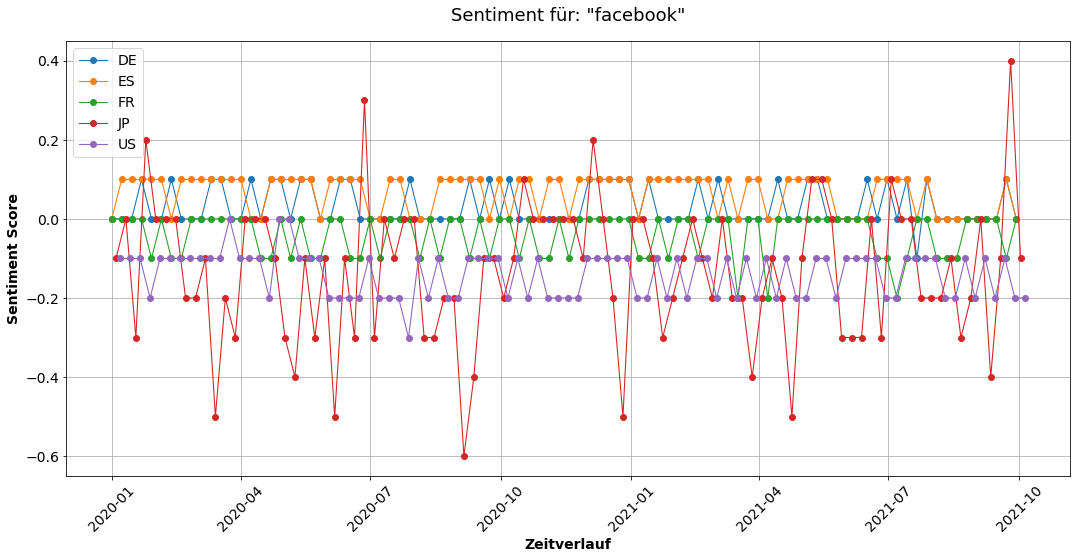

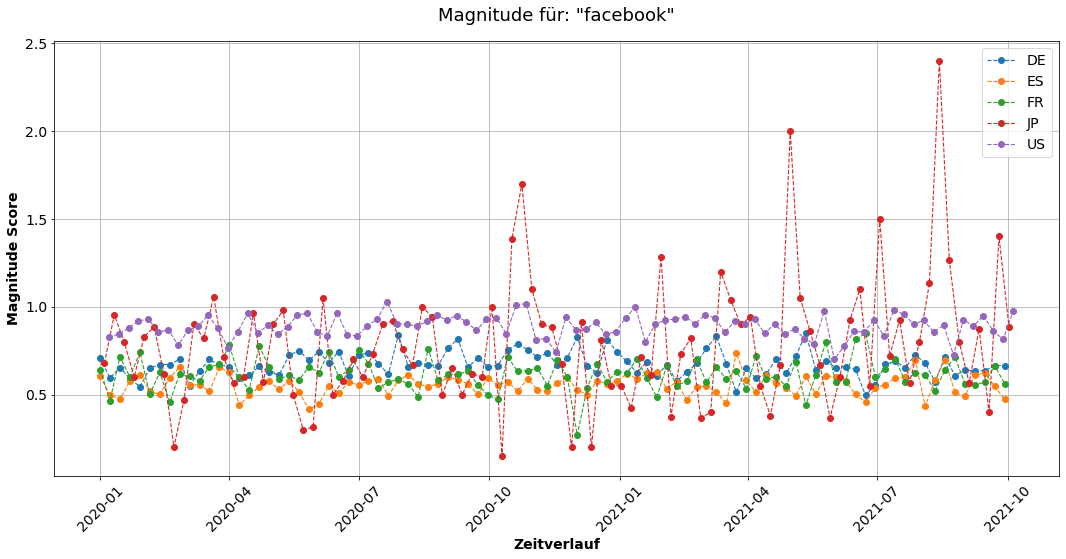

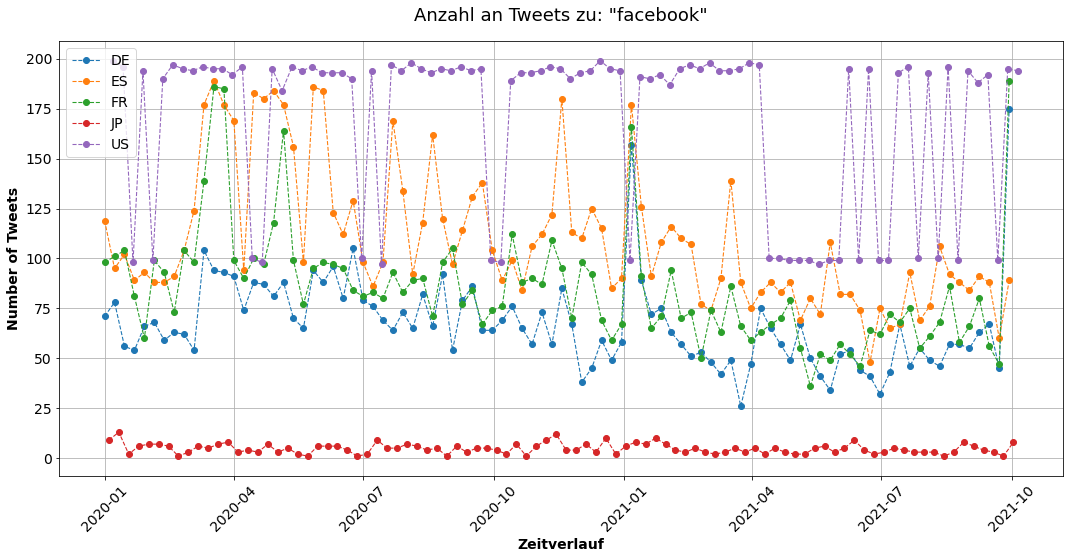

In [22]:
sentiment_df.rename(columns={'id': 'number_of_tweets'}, inplace=True)

os.makedirs('./results', exist_ok=True)
sentiment_df.to_csv('./results/{}.csv'.format(search_term), sep=';')

# Adjust figure appearance and scale
font = {
    'family': 'sans-serif',
    'weight': 'normal',
    'size': 14
}
plt.rc("font", **font)
plt.rc("lines", linewidth=1.1)

y_label_params = {
    'fontfamily': "sans-serif",
    'weight': "bold",
    'fontsize': font['size']
}

for plotted_value in ['sentiment', 'magnitude', 'number_of_tweets']:
    fig, ax = plt.subplots(figsize=(18, 8))

    groups = sentiment_df.index.levels[0]

    for group in groups:
        if plotted_value == 'sentiment':
            ax.plot(sentiment_df.loc[(group)].score, 'o-', label=group)
            ax.set_ylabel("Sentiment Score", **y_label_params)
            plt.title('Sentiment für: "{}"'.format(search_term), fontfamily="sans-serif", fontsize=18, pad=20)
        elif plotted_value == 'magnitude':
            ax.plot(sentiment_df.loc[(group)].magnitude / sentiment_df.loc[(group)].number_of_tweets, 'o--', label=group)
            ax.set_ylabel("Magnitude Score", **y_label_params)
            plt.title('Magnitude für: "{}"'.format(search_term), fontfamily="sans-serif", fontsize=18, pad=20)
        else:
            ax.plot(sentiment_df.loc[(group)].number_of_tweets, 'o--', label=group)
            ax.set_ylabel("Number of Tweets", **y_label_params)
            plt.title('Anzahl an Tweets zu: "{}"'.format(search_term), fontfamily="sans-serif", fontsize=18, pad=20)

    ax.set_xlabel("Zeitverlauf", fontfamily="sans-serif",
                weight="bold", fontsize=font['size'])
    ax.grid()
    ax.legend(loc='best')
    plt.xticks(rotation=45)
    #plt.show()
    plt.savefig('./results/{}_{}.png'.format(search_term, plotted_value), bbox_inches='tight')
